In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
# Load data using pandas
data_sample = pd.read_csv('data.csv', header=None).to_numpy()
print(data_sample)

[[3.304500e+00 1.000000e+00]
 [2.198375e+00 1.000000e+03]
 [1.825625e+00 1.500000e+03]
 [1.564000e+00 2.000000e+03]
 [1.210500e+00 3.000000e+03]
 [1.076500e+00 3.500000e+03]]


[ 6.69309291e+03  7.11199618e-01 -2.85126720e+03]
75.33963505937572
5774.407361893345


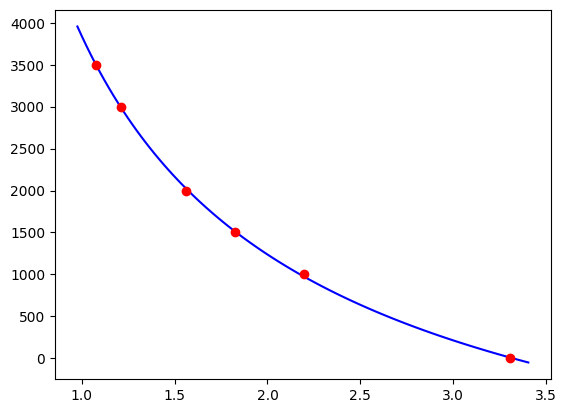

In [26]:



def func(x, a, b,c):
    return a/x**b + c

popt, pcov = curve_fit(func, data_sample[:,0], data_sample[:,1])
print(popt)

x = np.linspace(np.min(data_sample[:,0])-0.1, np.max(data_sample[:,0] + 0.1), 100)
print(func(3.2,*popt))
print(func(0.7,*popt))
#plt.yscale('log')
plt.plot(x, func(x, *popt), 'b-')
plt.plot(data_sample[:,0], data_sample[:,1], 'ro')

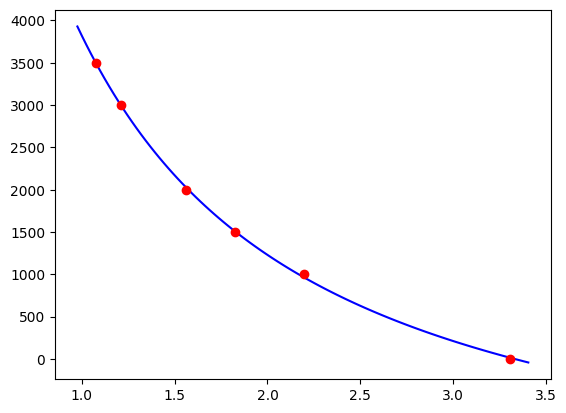

In [8]:
a = -1387.07
b = 7263.86
c = -2055.30

plt.plot(x, func(x, a,b,c), 'b-')
plt.plot(data_sample[:,0], data_sample[:,1], 'ro')